Overall idea is to implement a relative-value strategy.

Commodities often implement strategies for spreads between 2 instruments and ocassionally things like spread of spreads. 

Core idea is that, when a dislocation occurs, you bet on the dislocation going away.

Whether or not there is a dislocation would be judged by looking at the Z-score.

The lack of forward curves in crypto markets means timing spreads cannot really be implemented. (eg. calendar / quarter strips).

Instruments used below are BTCUSD / ETHUSD / SOLUSD / XRPUSD.

Future ideas:
- cross exchange arb
- algebraic similarity arb (eg. (ETHUSD−XRPUSD)−(SOLUSD−XRPUSD) Simplifies to the spread --> ETHUSD−SOLUSD) but though algebraically equivalent. there might be arbs within this expression due to liquidity mismatch.

1) Load 5-minute price data for Bitcoin (BTC) and Ethereum (ETH) from multiple CSV files, aligns both datasets by their timestamps, calculates the price difference (spread) between BTC and ETH, and then cleans the data so only consecutive 5-minute intervals remain.

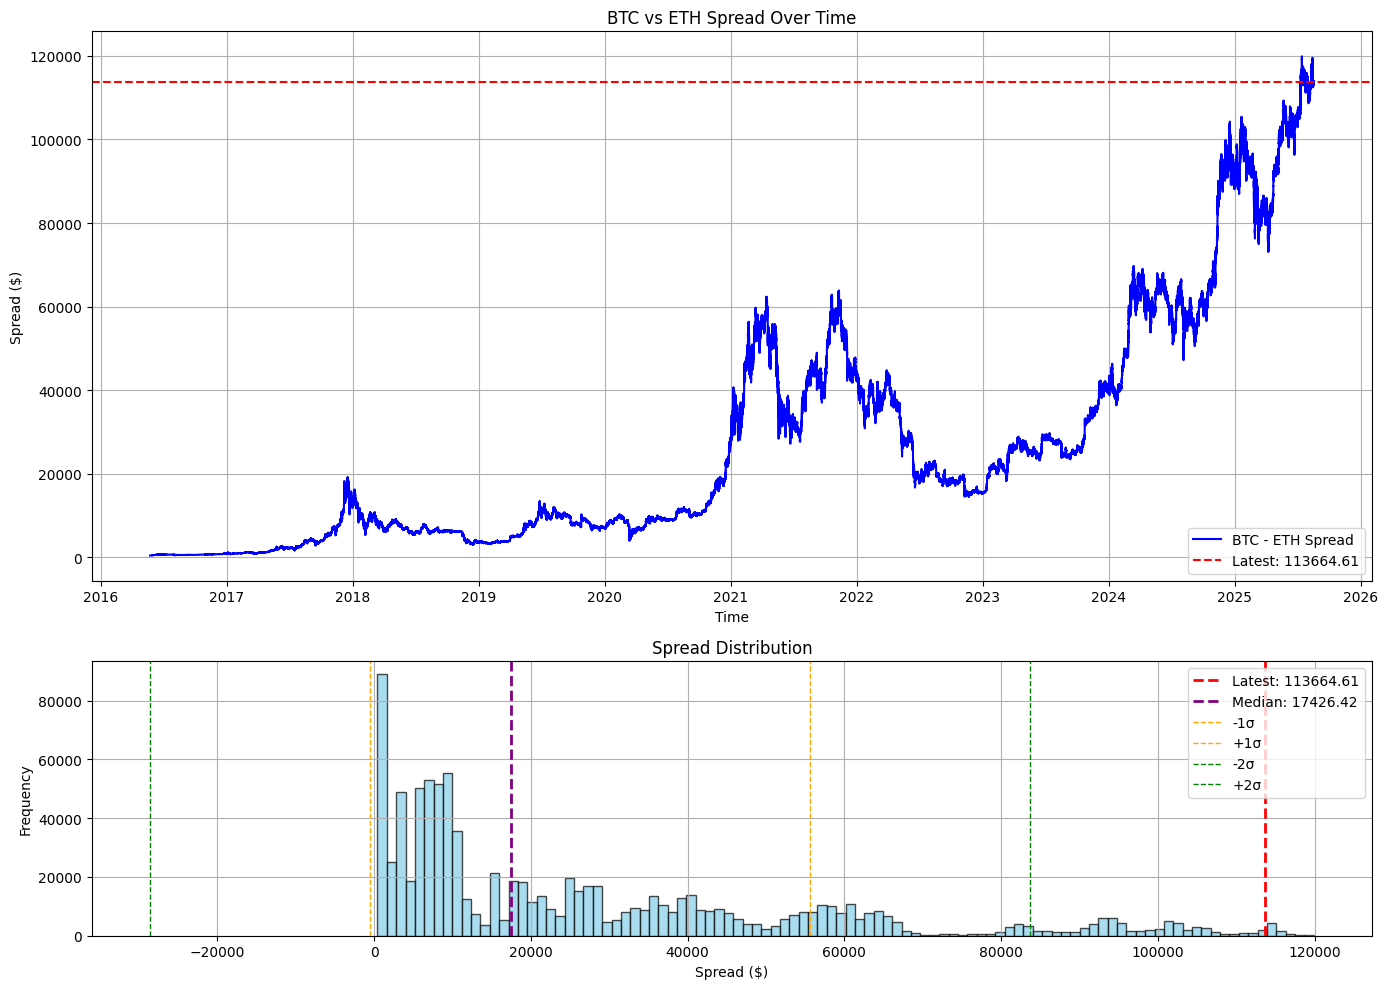

In [18]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt

# Define expected column structure
columns = ['time', 'open', 'high', 'low', 'close', 'volume']

# Load BTCUSD CSVs
btc_files = sorted(glob.glob("crypto_research/coinbase/5m/*/BTCUSD_5m_*.csv"))
df_btc = pd.concat(
    [pd.read_csv(f, names=columns, header=None, on_bad_lines='skip') for f in btc_files],
    ignore_index=True
)

# Load ETHUSD CSVs
eth_files = sorted(glob.glob("crypto_research/coinbase/5m/*/ETHUSD_5m_*.csv"))
df_eth = pd.concat(
    [pd.read_csv(f, names=columns, header=None, on_bad_lines='skip') for f in eth_files],
    ignore_index=True
)

# Clean data
df_btc.dropna(subset=['time', 'close'], inplace=True)
df_eth.dropna(subset=['time', 'close'], inplace=True)
df_btc['time'] = df_btc['time'].astype(int)
df_eth['time'] = df_eth['time'].astype(int)

# Determine common time range
start = max(df_btc['time'].min(), df_eth['time'].min())
end = min(df_btc['time'].max(), df_eth['time'].max())
full_time_index = np.arange(start, end + 1, 300)  # 5 minutes

# Reindex to align timestamps
df_btc = df_btc.set_index('time').reindex(full_time_index)
df_eth = df_eth.set_index('time').reindex(full_time_index)

# Drop rows where either close is NaN
df = pd.DataFrame({
    'time': full_time_index,
    'close_btc': df_btc['close'],
    'close_eth': df_eth['close']
})
df.dropna(subset=['close_btc', 'close_eth'], inplace=True)

# Calculate spread and convert time
df['spread'] = df['close_btc'].astype(float) - df['close_eth'].astype(float)
df['datetime'] = pd.to_datetime(df['time'], unit='s')

# Compute statistics for histogram
latest_value = df['spread'].iloc[-1]
median_spread = df['spread'].median()
mean_spread = df['spread'].mean()
std_spread = df['spread'].std()

# Plot spread and histogram as subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [2, 1]})

# Plot 1: Spread over time
axs[0].plot(df['datetime'], df['spread'], label='BTC - ETH Spread', color='blue')
axs[0].axhline(latest_value, color='red', linestyle='--', label=f'Latest: {latest_value:.2f}')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Spread ($)')
axs[0].set_title('BTC vs ETH Spread Over Time')
axs[0].grid(True)
axs[0].legend()

# Plot 2: Histogram with stats
axs[1].hist(df['spread'], bins=100, color='skyblue', edgecolor='black', alpha=0.7)
axs[1].axvline(latest_value, color='red', linestyle='--', linewidth=2, label=f'Latest: {latest_value:.2f}')
axs[1].axvline(median_spread, color='purple', linestyle='--', linewidth=2, label=f'Median: {median_spread:.2f}')
axs[1].axvline(mean_spread - std_spread, color='orange', linestyle='--', linewidth=1, label='-1σ')
axs[1].axvline(mean_spread + std_spread, color='orange', linestyle='--', linewidth=1, label='+1σ')
axs[1].axvline(mean_spread - 2*std_spread, color='green', linestyle='--', linewidth=1, label='-2σ')
axs[1].axvline(mean_spread + 2*std_spread, color='green', linestyle='--', linewidth=1, label='+2σ')
axs[1].set_xlabel('Spread ($)')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Spread Distribution')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


1.1) Step 1 but just for 2025 data - just for visualization to see histogram changes.

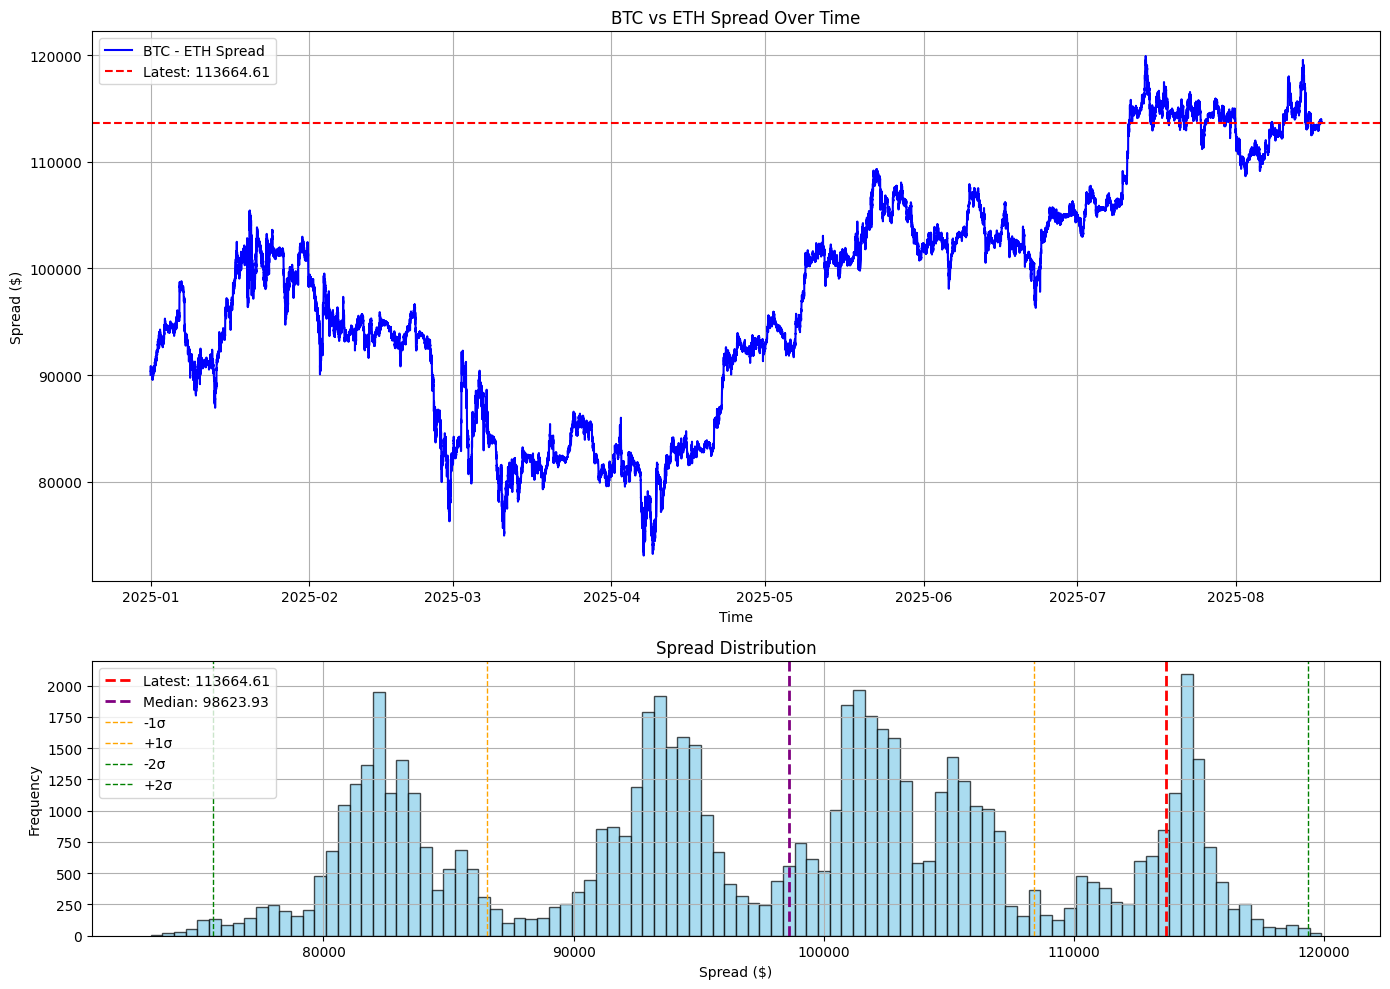

In [23]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt

# Define expected column structure
columns = ['time', 'open', 'high', 'low', 'close', 'volume']

# Load BTCUSD CSVs
btc_files = sorted(glob.glob("crypto_research/coinbase/5m/*/BTCUSD_5m_*.csv"))
df_btc = pd.concat(
    [pd.read_csv(f, names=columns, header=None, on_bad_lines='skip') for f in btc_files],
    ignore_index=True
)

# Load ETHUSD CSVs
eth_files = sorted(glob.glob("crypto_research/coinbase/5m/*/ETHUSD_5m_*.csv"))
df_eth = pd.concat(
    [pd.read_csv(f, names=columns, header=None, on_bad_lines='skip') for f in eth_files],
    ignore_index=True
)

# Clean data
df_btc.dropna(subset=['time', 'close'], inplace=True)
df_eth.dropna(subset=['time', 'close'], inplace=True)
df_btc['time'] = df_btc['time'].astype(int)
df_eth['time'] = df_eth['time'].astype(int)

# Determine common time range
start = max(df_btc['time'].min(), df_eth['time'].min())
end = min(df_btc['time'].max(), df_eth['time'].max())
full_time_index = np.arange(start, end + 1, 300)  # 5 minutes

# Reindex to align timestamps
df_btc = df_btc.set_index('time').reindex(full_time_index)
df_eth = df_eth.set_index('time').reindex(full_time_index)

# Drop rows where either close is NaN
df = pd.DataFrame({
    'time': full_time_index,
    'close_btc': df_btc['close'],
    'close_eth': df_eth['close']
})
df.dropna(subset=['close_btc', 'close_eth'], inplace=True)

# Calculate spread and convert time
df['spread'] = df['close_btc'].astype(float) - df['close_eth'].astype(float)
df['datetime'] = pd.to_datetime(df['time'], unit='s')
df = df[df['datetime'].dt.year == 2025]


# Compute statistics for histogram
latest_value = df['spread'].iloc[-1]
median_spread = df['spread'].median()
mean_spread = df['spread'].mean()
std_spread = df['spread'].std()

# Plot spread and histogram as subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [2, 1]})

# Plot 1: Spread over time
axs[0].plot(df['datetime'], df['spread'], label='BTC - ETH Spread', color='blue')
axs[0].axhline(latest_value, color='red', linestyle='--', label=f'Latest: {latest_value:.2f}')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Spread ($)')
axs[0].set_title('BTC vs ETH Spread Over Time')
axs[0].grid(True)
axs[0].legend()

# Plot 2: Histogram with stats
axs[1].hist(df['spread'], bins=100, color='skyblue', edgecolor='black', alpha=0.7)
axs[1].axvline(latest_value, color='red', linestyle='--', linewidth=2, label=f'Latest: {latest_value:.2f}')
axs[1].axvline(median_spread, color='purple', linestyle='--', linewidth=2, label=f'Median: {median_spread:.2f}')
axs[1].axvline(mean_spread - std_spread, color='orange', linestyle='--', linewidth=1, label='-1σ')
axs[1].axvline(mean_spread + std_spread, color='orange', linestyle='--', linewidth=1, label='+1σ')
axs[1].axvline(mean_spread - 2*std_spread, color='green', linestyle='--', linewidth=1, label='-2σ')
axs[1].axvline(mean_spread + 2*std_spread, color='green', linestyle='--', linewidth=1, label='+2σ')
axs[1].set_xlabel('Spread ($)')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Spread Distribution')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


2) Do Step 1 for all possible spreads & spread-of-spread combinations within the 4 instruments. Add a ranking table to rank the spread dislocations. This would be the latest snapshot.

Plotting spreads with histograms...


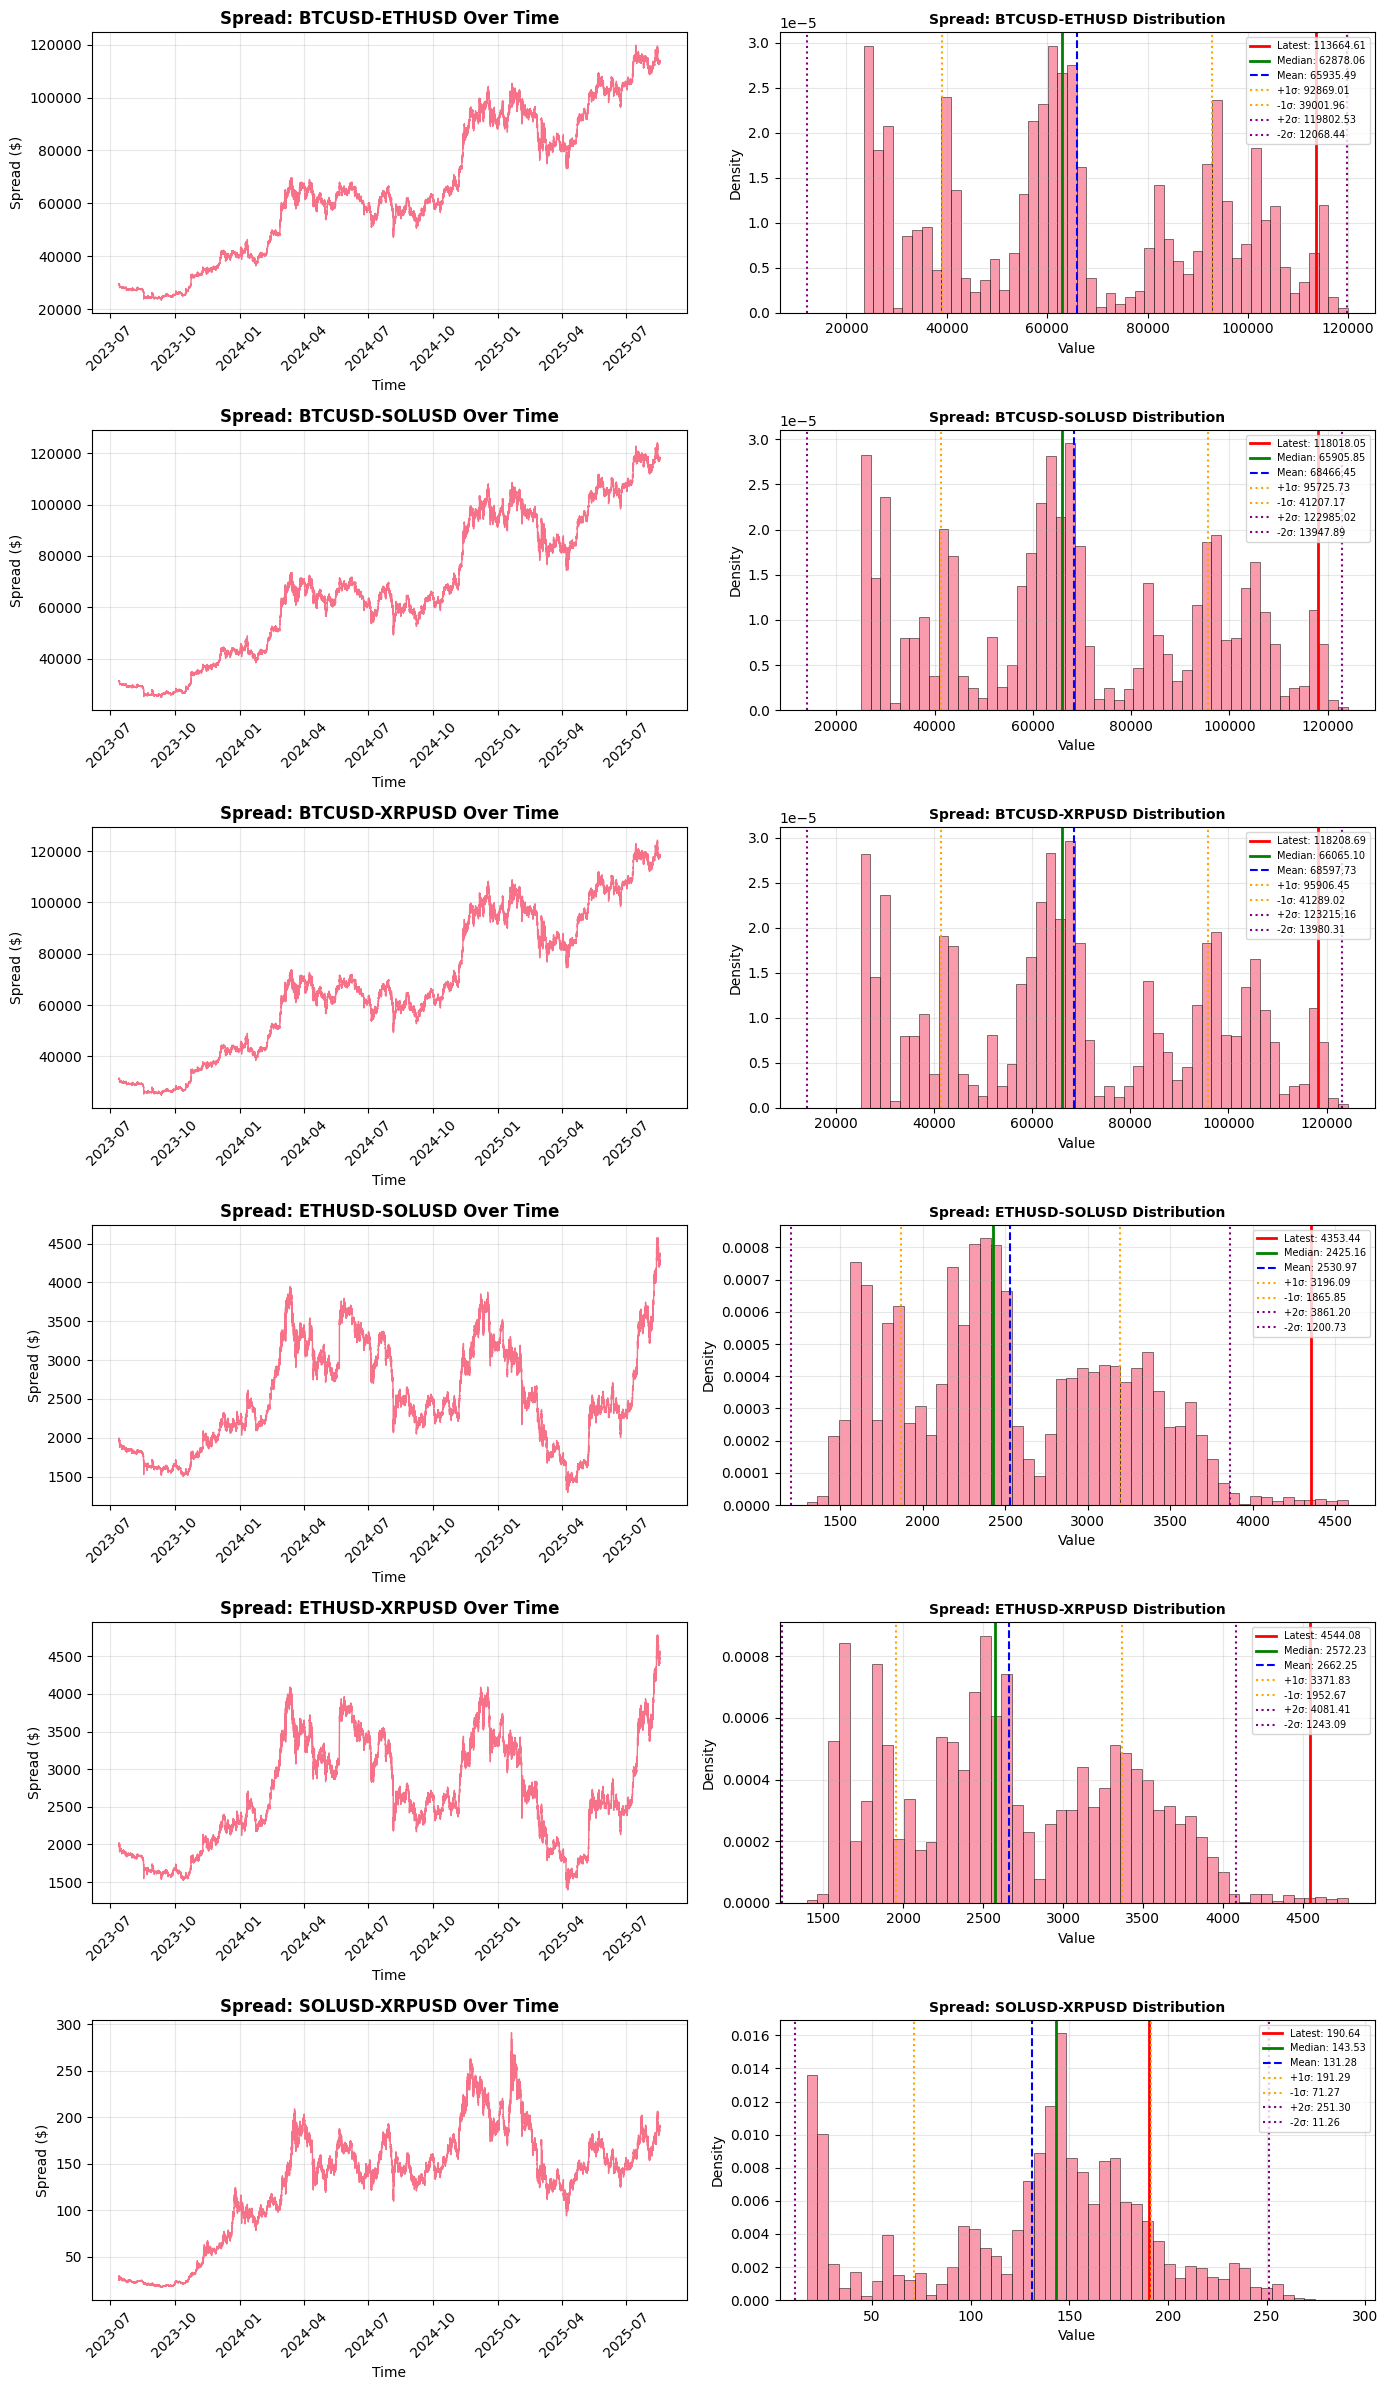

Plotting spread-of-spreads with histograms...


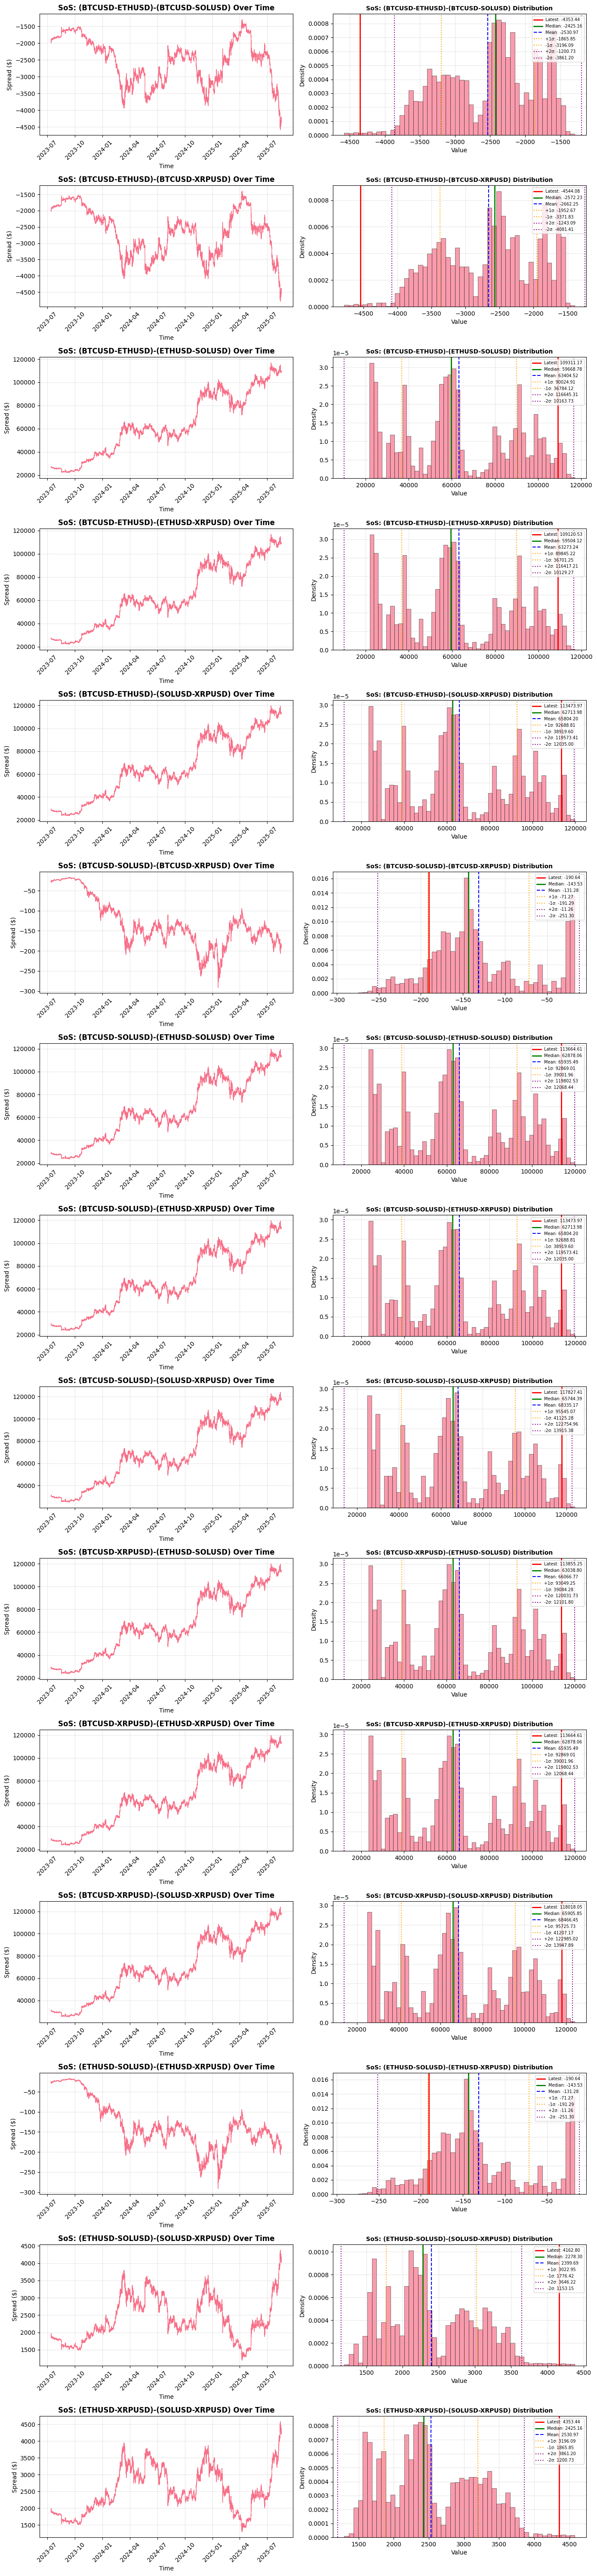


Calculating Z-scores and ranking spreads & spread-of-spreads...

🔍 Ranked Spreads and Spread-of-Spreads by Absolute Z-Score:

                               Name              Type  Latest Value      Mean   Std Dev  Z-score  Abs Z-score
0   (ETHUSD-SOLUSD)-(SOLUSD-XRPUSD)  Spread-of-Spread      4162.797  2399.686   623.268    2.829        2.829
1   (BTCUSD-ETHUSD)-(BTCUSD-SOLUSD)  Spread-of-Spread     -4353.440 -2530.967   665.118   -2.740        2.740
2   (ETHUSD-XRPUSD)-(SOLUSD-XRPUSD)  Spread-of-Spread      4353.440  2530.967   665.118    2.740        2.740
3                     ETHUSD-SOLUSD            Spread      4353.440  2530.967   665.118    2.740        2.740
4   (BTCUSD-ETHUSD)-(BTCUSD-XRPUSD)  Spread-of-Spread     -4544.083 -2662.247   709.581   -2.652        2.652
5                     ETHUSD-XRPUSD            Spread      4544.083  2662.247   709.581    2.652        2.652
6   (BTCUSD-SOLUSD)-(SOLUSD-XRPUSD)  Spread-of-Spread    117827.407 68335.172 27209.894    1.819       

In [21]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import seaborn as sns

plt.style.use('default')
sns.set_palette("husl")

def load_crypto_data(symbol):
    columns = ['time', 'open', 'high', 'low', 'close', 'volume']
    files = sorted(glob.glob(f"crypto_research/coinbase/5m/*/{symbol}_5m_*.csv"))
    if not files:
        print(f"No files found for {symbol}")
        return None
    df = pd.concat(
        [pd.read_csv(f, names=columns, header=None, on_bad_lines='skip') for f in files],
        ignore_index=True
    )
    df.dropna(subset=['time', 'close'], inplace=True)
    df['time'] = df['time'].astype(int)
    df['close'] = df['close'].astype(float)
    return df

def align_dataframes(dataframes, symbols):
    start = max(df['time'].min() for df in dataframes.values())
    end = min(df['time'].max() for df in dataframes.values())
    full_time_index = np.arange(start, end + 1, 300)
    aligned_data = {'time': full_time_index}
    for symbol, df in dataframes.items():
        df_indexed = df.set_index('time').reindex(full_time_index)
        aligned_data[f'close_{symbol.lower()}'] = df_indexed['close']
    combined_df = pd.DataFrame(aligned_data)
    combined_df.dropna(inplace=True)
    combined_df['datetime'] = pd.to_datetime(combined_df['time'], unit='s')
    return combined_df

def calculate_spreads(df, symbols):
    spreads = {}
    for sym1, sym2 in combinations(symbols, 2):
        spread_name = f"{sym1}-{sym2}"
        col1 = f"close_{sym1.lower()}"
        col2 = f"close_{sym2.lower()}"
        spreads[spread_name] = df[col1] - df[col2]
    return spreads

def plot_time_and_hist(spread_data, datetime_index, title, axes):
    # Time series
    axes[0].plot(datetime_index, spread_data, linewidth=1)
    axes[0].set_title(f'{title} Over Time', fontweight='bold')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Spread ($)')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, alpha=0.3)

    # Histogram with stats
    latest = spread_data.iloc[-1]
    median = spread_data.median()
    std = spread_data.std()
    mean = spread_data.mean()
    axes[1].hist(spread_data, bins=50, alpha=0.7, density=True, edgecolor='black', linewidth=0.5)
    axes[1].axvline(latest, color='red', linestyle='-', linewidth=2, label=f'Latest: {latest:.2f}')
    axes[1].axvline(median, color='green', linestyle='-', linewidth=2, label=f'Median: {median:.2f}')
    axes[1].axvline(mean, color='blue', linestyle='--', linewidth=1.5, label=f'Mean: {mean:.2f}')
    axes[1].axvline(mean + std, color='orange', linestyle=':', linewidth=1.5, label=f'+1σ: {mean + std:.2f}')
    axes[1].axvline(mean - std, color='orange', linestyle=':', linewidth=1.5, label=f'-1σ: {mean - std:.2f}')
    axes[1].axvline(mean + 2*std, color='purple', linestyle=':', linewidth=1.5, label=f'+2σ: {mean + 2*std:.2f}')
    axes[1].axvline(mean - 2*std, color='purple', linestyle=':', linewidth=1.5, label=f'-2σ: {mean - 2*std:.2f}')
    axes[1].set_title(f'{title} Distribution', fontsize=10, fontweight='bold')
    axes[1].set_xlabel('Value')
    axes[1].set_ylabel('Density')
    axes[1].legend(fontsize=7, loc='upper right')
    axes[1].grid(True, alpha=0.3)

def main():
    symbols = ['BTCUSD', 'ETHUSD', 'SOLUSD', 'XRPUSD']
    dataframes = {symbol: load_crypto_data(symbol) for symbol in symbols if load_crypto_data(symbol) is not None}
    if len(dataframes) < 2:
        print("Need at least 2 symbols to calculate spreads")
        return
    symbols = list(dataframes.keys())
    df = align_dataframes(dataframes, symbols)
    spreads = calculate_spreads(df, symbols)

    for name, data in spreads.items():
        df[f'spread_{name}'] = data

    spread_of_spreads = {}
    for s1, s2 in combinations(spreads.keys(), 2):
        sos_name = f"({s1})-({s2})"
        spread_of_spreads[sos_name] = spreads[s1] - spreads[s2]
        df[f'sos_{sos_name}'] = spread_of_spreads[sos_name]

    # Combined plots for each spread
    print("Plotting spreads with histograms...")
    fig_spreads, axes_spreads = plt.subplots(len(spreads), 2, figsize=(14, 4 * len(spreads)))
    if len(spreads) == 1:
        axes_spreads = [axes_spreads]
    for i, (name, data) in enumerate(spreads.items()):
        plot_time_and_hist(data, df['datetime'], f"Spread: {name}", axes_spreads[i])
    plt.tight_layout()
    plt.show()

    # Combined plots for each spread-of-spread
    if spread_of_spreads:
        print("Plotting spread-of-spreads with histograms...")
        fig_sos, axes_sos = plt.subplots(len(spread_of_spreads), 2, figsize=(14, 4 * len(spread_of_spreads)))
        if len(spread_of_spreads) == 1:
            axes_sos = [axes_sos]
        for i, (name, data) in enumerate(spread_of_spreads.items()):
            plot_time_and_hist(data, df['datetime'], f"SoS: {name}", axes_sos[i])
        plt.tight_layout()
        plt.show()

    # --- Ranking Table of Z-scores ---
    print("\nCalculating Z-scores and ranking spreads & spread-of-spreads...")

    ranking_data = []

    def compute_z_stats(name, series, type_label):
        latest = series.iloc[-1]
        mean = series.mean()
        std = series.std()
        if std == 0:
            z = np.nan
        else:
            z = (latest - mean) / std
        abs_z = abs(z)
        ranking_data.append({
            'Name': name,
            'Type': type_label,
            'Latest Value': latest,
            'Mean': mean,
            'Std Dev': std,
            'Z-score': z,
            'Abs Z-score': abs_z
        })

    for name, series in spreads.items():
        compute_z_stats(name, series, "Spread")
    for name, series in spread_of_spreads.items():
        compute_z_stats(name, series, "Spread-of-Spread")

    ranking_df = pd.DataFrame(ranking_data)
    ranking_df.sort_values(by='Abs Z-score', ascending=False, inplace=True)
    ranking_df.reset_index(drop=True, inplace=True)

    print("\n🔍 Ranked Spreads and Spread-of-Spreads by Absolute Z-Score:\n")
    print(ranking_df.to_string(index=True, float_format="%.3f"))

if __name__ == "__main__":
    main()


2.1) Step 2 shows latest snapshot, below shows how dislocations changed over time --> 30 day intervals

Walking forward 211852 steps with 8640-bar look-back...


100%|██████████| 211852/211852 [34:22<00:00, 102.73it/s] 


Saved full ranking history to ranking_history.csv


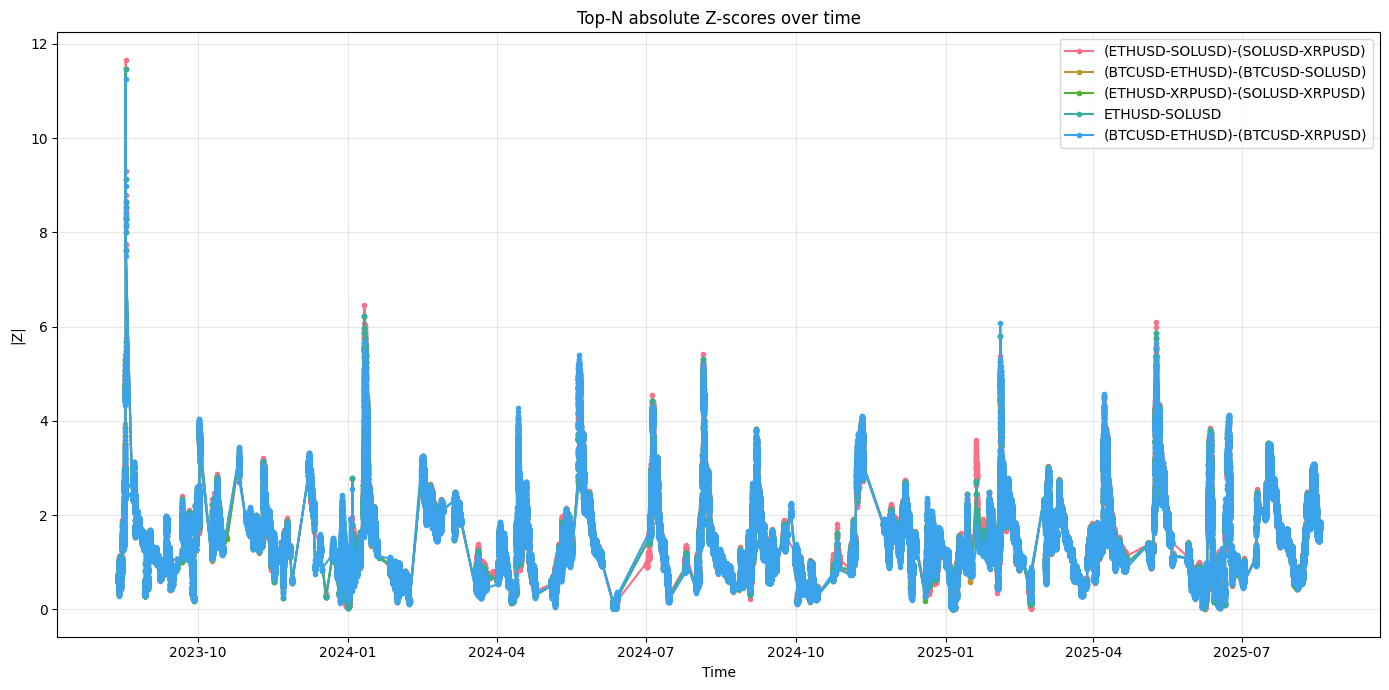

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import seaborn as sns
import glob
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
sns.set_palette("husl")

# -------------------------------------------------
# ONLY USER-ADJUSTABLE CONSTANT
# -------------------------------------------------
ROLLING_LOOKBACK_DAYS = 30          # <-- change this (days)
max_workers = os.cpu_count()
# -------------------------------------------------
# DERIVED CONSTANTS – DO NOT CHANGE
# -------------------------------------------------
FREQ_MINUTES   = 5                  # data frequency
BARS_PER_DAY   = 24 * 60 // FREQ_MINUTES        # 288 for 5-min
ROLLING_LOOKBACK_BARS = ROLLING_LOOKBACK_DAYS * BARS_PER_DAY

# -------------------------------------------------
# Re-use your existing helpers (unchanged)
# -------------------------------------------------
def load_crypto_data(symbol):
    columns = ['time', 'open', 'high', 'low', 'close', 'volume']
    files = sorted(glob.glob(f"crypto_research/coinbase/5m/*/{symbol}_5m_*.csv"))
    if not files:
        print(f"No files found for {symbol}")
        return None
    df = pd.concat(
        [pd.read_csv(f, names=columns, header=None, on_bad_lines='skip') for f in files],
        ignore_index=True
    )
    df.dropna(subset=['time', 'close'], inplace=True)
    df['time'] = df['time'].astype(int)
    df['close'] = df['close'].astype(float)
    return df

def align_dataframes(dataframes, symbols):
    start = max(df['time'].min() for df in dataframes.values())
    end = min(df['time'].max() for df in dataframes.values())
    full_time_index = np.arange(start, end + 1, FREQ_MINUTES * 60)
    aligned_data = {'time': full_time_index}
    for symbol, df in dataframes.items():
        df_indexed = df.set_index('time').reindex(full_time_index)
        aligned_data[f'close_{symbol.lower()}'] = df_indexed['close']
    combined_df = pd.DataFrame(aligned_data)
    combined_df.dropna(inplace=True)
    combined_df['datetime'] = pd.to_datetime(combined_df['time'], unit='s')
    return combined_df

def calculate_spreads(df, symbols):
    spreads = {}
    for sym1, sym2 in combinations(symbols, 2):
        spread_name = f"{sym1}-{sym2}"
        col1 = f"close_{sym1.lower()}"
        col2 = f"close_{sym2.lower()}"
        spreads[spread_name] = df[col1] - df[col2]
    return spreads

def compute_ranking_for_window(df, spreads, spread_of_spreads, start_idx, end_idx, top_n):
    window_df = df.iloc[start_idx:end_idx+1]

    ranking_rows = []
    for name in spreads.keys():
        s = window_df[f'spread_{name}']
        latest, mean, std = s.iloc[-1], s.mean(), s.std()
        z = np.nan if std == 0 else (latest - mean) / std
        ranking_rows.append({
            'datetime': window_df['datetime'].iloc[-1],
            'Name': name,
            'Type': 'Spread',
            'Z': z,
            'AbsZ': abs(z)
        })

    for name in spread_of_spreads.keys():
        s = window_df[f'sos_{name}']
        latest, mean, std = s.iloc[-1], s.mean(), s.std()
        z = np.nan if std == 0 else (latest - mean) / std
        ranking_rows.append({
            'datetime': window_df['datetime'].iloc[-1],
            'Name': name,
            'Type': 'SoS',
            'Z': z,
            'AbsZ': abs(z)
        })

    ranking_step = pd.DataFrame(ranking_rows).sort_values(
        by='AbsZ', ascending=False).head(top_n).reset_index(drop=True)
    return ranking_step, window_df['datetime'].iloc[-1]

# -------------------------------------------------
# Walk-forward ranking engine
# -------------------------------------------------
def walk_forward_rankings(df, symbols,
                          lookback_bars,
                          top_n=10,
                          max_workers=os.cpu_count()):   
    ranking_history = []
    timestamps = []

    spreads = calculate_spreads(df, symbols)
    for name, series in spreads.items():
        df[f'spread_{name}'] = series

    spread_of_spreads = {}
    for s1, s2 in combinations(spreads.keys(), 2):
        sos_name = f"({s1})-({s2})"
        spread_of_spreads[sos_name] = spreads[s1] - spreads[s2]
        df[f'sos_{sos_name}'] = spread_of_spreads[sos_name]

    total_steps = len(df) - lookback_bars + 1
    print(f"Walking forward {total_steps} steps with {lookback_bars}-bar look-back...")

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for end_idx in range(lookback_bars - 1, len(df)):
            start_idx = end_idx - lookback_bars + 1
            futures.append(executor.submit(
                compute_ranking_for_window, df, spreads, spread_of_spreads,
                start_idx, end_idx, top_n))

        # Wrap the list, not as_completed
        for f in tqdm(futures, total=total_steps):
            ranking_step, timestamp = f.result()
            ranking_history.append(ranking_step)
            timestamps.append(timestamp)

    return ranking_history, timestamps

# -------------------------------------------------
# Plot helpers
# -------------------------------------------------
def plot_rank_evolution(ranking_history, top_n=5):
    full = pd.concat(ranking_history, ignore_index=True)
    ever_top = full['Name'].unique()[:top_n]
    plt.figure(figsize=(14, 7))
    for name in ever_top:
        sub = full[full['Name'] == name]
        plt.plot(sub['datetime'], sub['AbsZ'], label=name, marker='o', markersize=3)
    plt.title("Top-N absolute Z-scores over time")
    plt.ylabel("|Z|")
    plt.xlabel("Time")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# -------------------------------------------------
# Main routine
# -------------------------------------------------
def main():
    symbols = ['BTCUSD', 'ETHUSD', 'SOLUSD', 'XRPUSD']
    dataframes = {symbol: load_crypto_data(symbol)
                  for symbol in symbols if load_crypto_data(symbol) is not None}
    if len(dataframes) < 2:
        print("Need at least 2 symbols")
        return
    symbols = list(dataframes.keys())
    df = align_dataframes(dataframes, symbols)

    ranking_history, timestamps = walk_forward_rankings(
        df, symbols, lookback_bars=ROLLING_LOOKBACK_BARS, top_n=10)

    full_history = pd.concat(ranking_history, ignore_index=True)
    full_history.to_csv("ranking_history.csv", index=False)
    print("Saved full ranking history to ranking_history.csv")

    plot_rank_evolution(ranking_history, top_n=5)

if __name__ == "__main__":
    main()

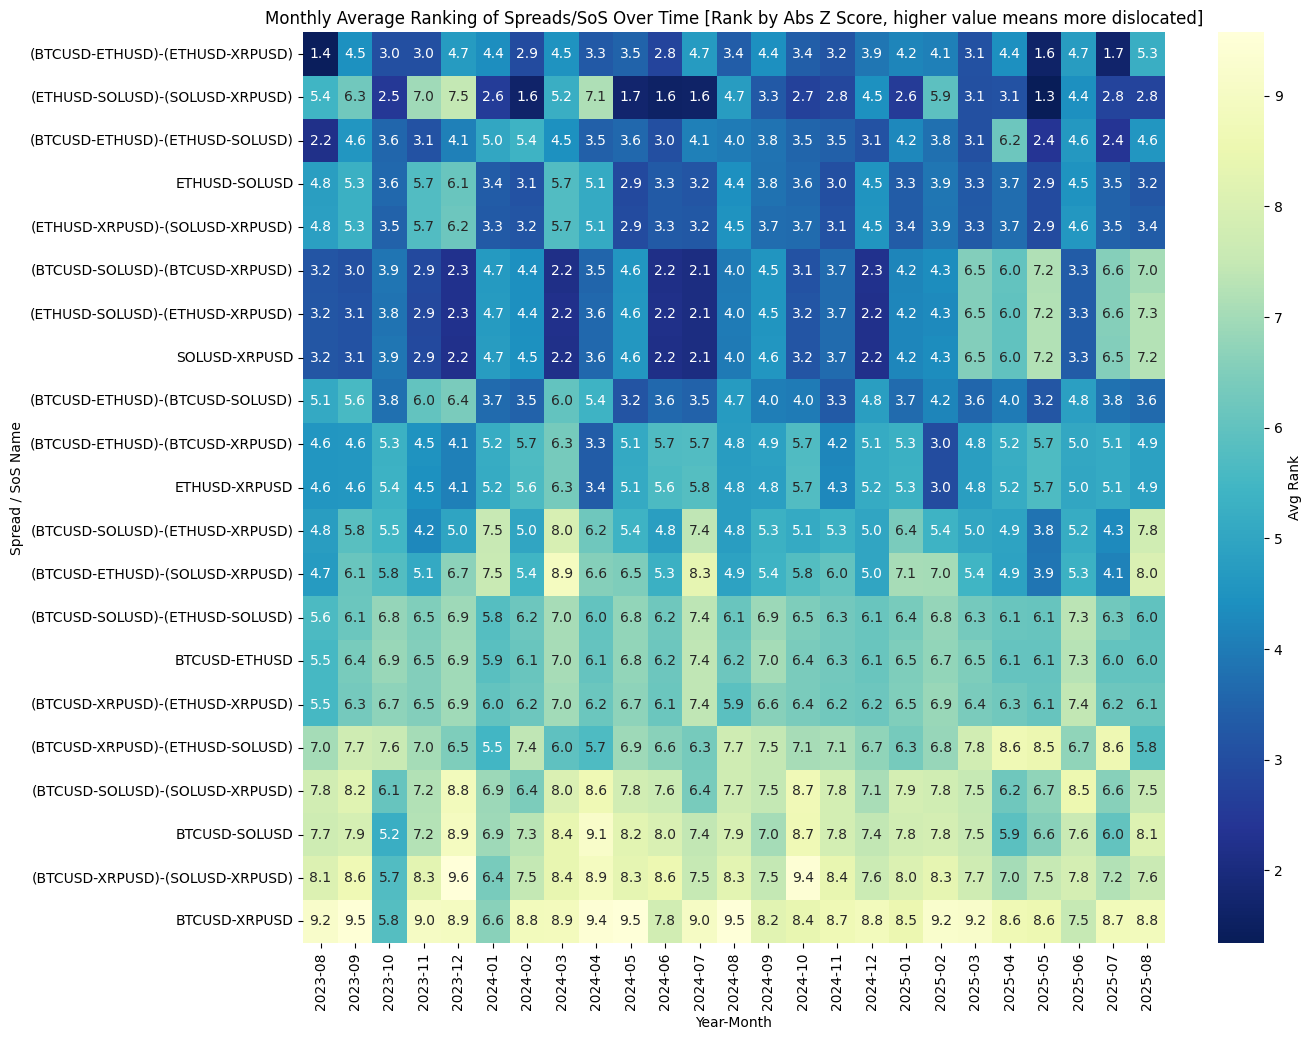

In [6]:
def plot_monthly_ranking_heatmap(csv_path, top_n=10):
    # Load data with datetime parsing
    df = pd.read_csv(csv_path, parse_dates=['datetime'])
    
    # Rank within each datetime by AbsZ (1=highest)
    df['Rank'] = df.groupby('datetime')['AbsZ'].rank(method='min', ascending=False)
    
    # Keep only top_n ranks per timestamp
    df = df[df['Rank'] <= top_n]
    
    # Extract year-month for grouping
    df['YearMonth'] = df['datetime'].dt.to_period('M').astype(str)
    
    # For each month and each Name, take the average rank
    monthly_rank = df.groupby(['YearMonth', 'Name'])['Rank'].mean().reset_index()
    
    # Pivot so rows = Names, columns = YearMonth, values = average rank
    heatmap_data = monthly_rank.pivot(index='Name', columns='YearMonth', values='Rank')
    
    # Sort spreads by overall average rank (ascending)
    heatmap_data = heatmap_data.loc[heatmap_data.mean(axis=1).sort_values().index]
    
    plt.figure(figsize=(14, max(6, len(heatmap_data)*0.5)))
    
    # Draw heatmap with coolwarm palette reversed so rank 1 is bright color
    sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap='YlGnBu_r', cbar_kws={'label': 'Avg Rank'})
    
    plt.title(f"Monthly Average Ranking of Spreads/SoS Over Time [Rank by Abs Z Score, higher value means more dislocated]")
    plt.ylabel("Spread / SoS Name")
    plt.xlabel("Year-Month")
    plt.tight_layout()
    plt.show()

# Plot average ranking over time
plot_monthly_ranking_heatmap("ranking_history.csv", top_n=20)


Spreads that involve BTCUSD tend to generally be more dislocated and remain dislocated over time.

<!-- 🔴 Bootstrap-based methods for feature selection and model training to work with easily-overfit (even in cross-validation set) data.
🔴 Ways to diversify feature influence inside linear, non-linear models to avoid over-reliance on a few signals.
🔴 Balancing trade-offs between higher win rate vs. betting on large magnitude moves.
🔴 Adversarial validation for regime shift detection.
🔴 Volatility modeling.
🔴 Methods to enforce ex-ante structures. -->


3) Linear regression to see if there is signal in dislocations. --> ONE TEST With the spread between BTCUSD and ETHUSD

Starting BTC-ETH Dislocation Signal Analysis...
Loading cryptocurrency data...


Loading symbols:  50%|█████     | 1/2 [00:01<00:01,  1.26s/it]

   BTCUSD: 65,849 bars loaded


Loading symbols: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it]

   ETHUSD: 65,843 bars loaded
Aligning dataframes...
Data alignment complete: 65,842 synchronized bars
Date range: 2025-01-01 00:00 to 2025-08-17 15:20
Available CPU cores: 22

Running parallel rolling regression analysis...
Preparing 56,915 rolling windows for parallel processing...
Using 16 CPU cores for parallel processing...
Processing in chunks of 889 windows...



Processing chunks:   0%|          | 0/65 [00:00<?, ?chunk/s]


Parallel processing failed (Can't pickle local object 'run_regression_parallel.<locals>.<lambda>'), falling back to sequential processing...


Processing windows (sequential): 100%|██████████| 56915/56915 [04:54<00:00, 193.38window/s]


Collected 170,745 regression results
Regression complete: 170,745 rolling windows analyzed
Saving results...
Saved: regression_results_2025_comprehensive.csv
Analyzing regression results...
Saved: regression_summary_2025_comprehensive.csv

COMPREHENSIVE DISLOCATION SIGNAL ANALYSIS REPORT

ANALYSIS PERIOD: 2025-01-30 to 2025-08-16
ROLLING WINDOW: 30 days (8640 bars)
FORWARD RETURN PERIOD: 288 bars (24.0 hours)

STRATEGY CONCEPT:
   • Calculate Z-score of BTC-ETH price spread over rolling 30-day window
   • LONG signal when Z < -1.0 (spread unusually low)
   • SHORT signal when Z > 1.0 (spread unusually high)
   • Measure forward returns to assess signal quality

RESULTS SUMMARY (Ranked by Expected Value):
----------------------------------------------------------------------------------------------------

RANK 1: BTCUSD-ETHUSD -> BTCUSD-ETHUSD_ret
   Strategy Expected Value: 0.011870 (118.70 bps)
   Win Rate: 69.2%
   Information Coefficient: -0.3143 (correlation: signal vs returns)
   

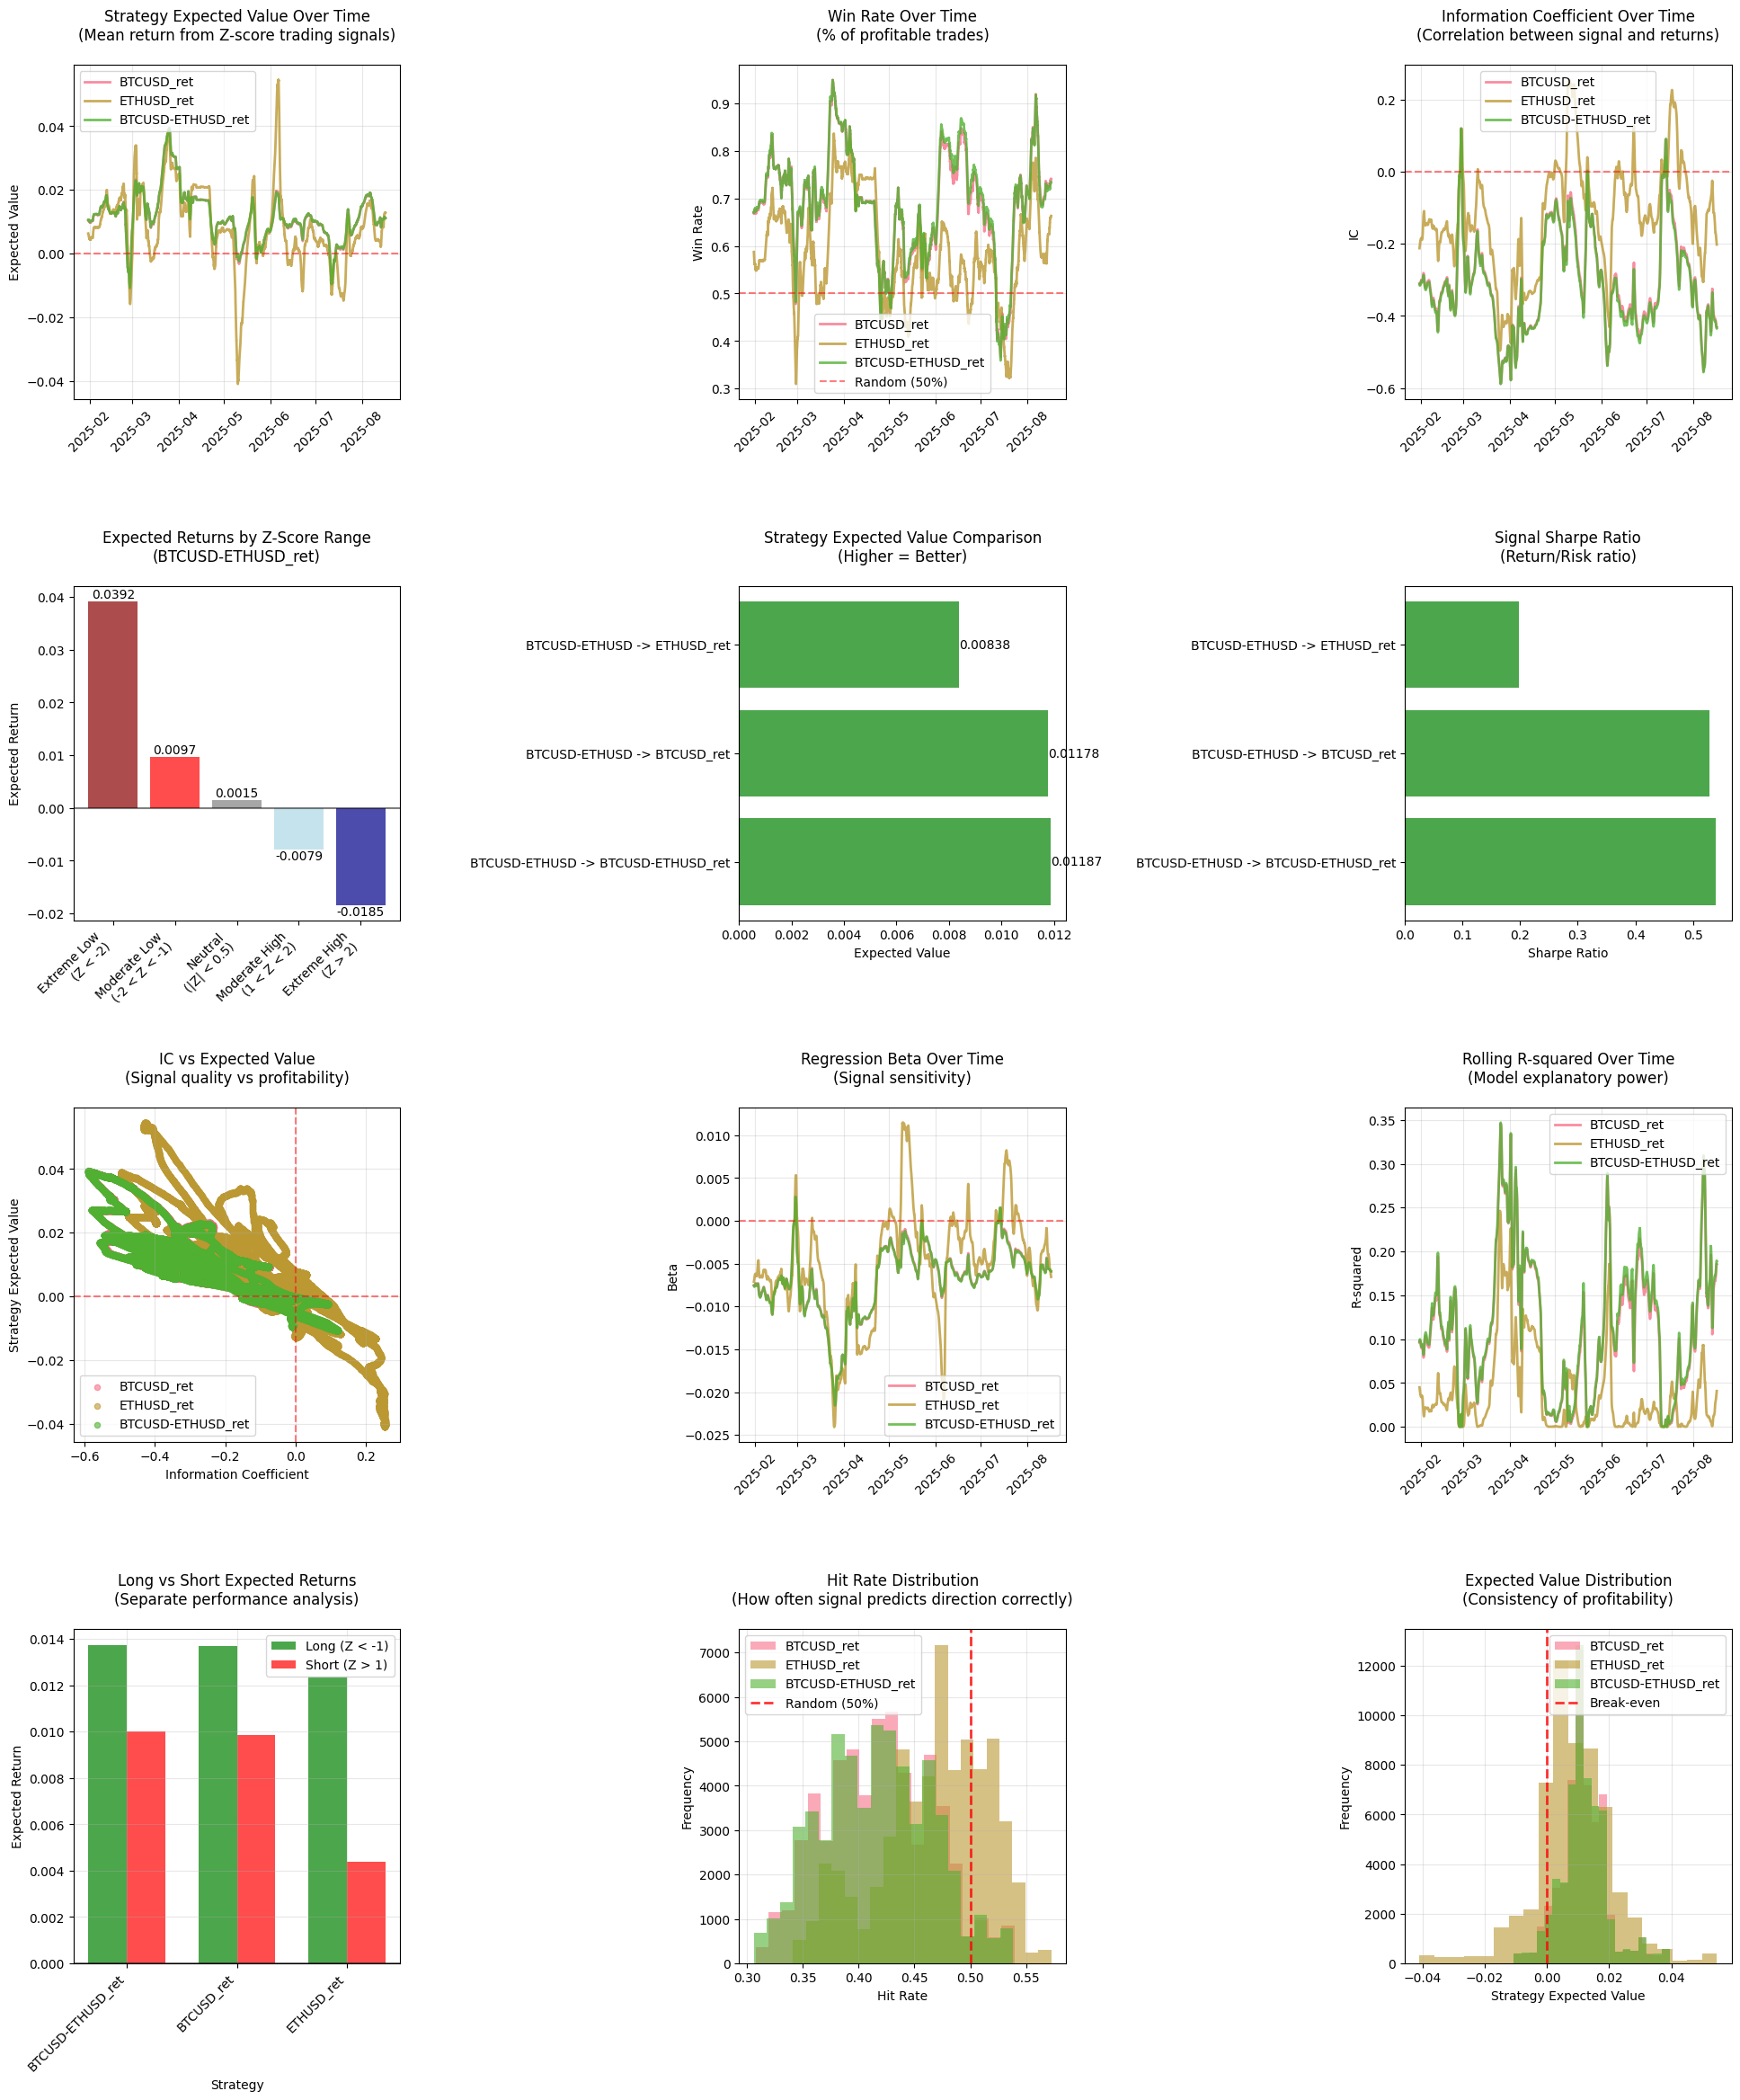


Analysis complete! Check the plots and CSV files for detailed results.


In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from multiprocessing import Pool, cpu_count
from functools import partial
import warnings
warnings.filterwarnings('ignore')

# -------------------------------------------------
# USER-ADJUSTABLE CONSTANTS
# -------------------------------------------------
ROLLING_LOOKBACK_DAYS = 30
FORWARD_RETURN_BARS = 288
FREQ_MINUTES = 5
BARS_PER_DAY = 24 * 60 // FREQ_MINUTES
ROLLING_LOOKBACK_BARS = ROLLING_LOOKBACK_DAYS * BARS_PER_DAY

# -------------------------------------------------
# Data loading helpers
# -------------------------------------------------
def load_crypto_data(symbol):
    columns = ['time', 'open', 'high', 'low', 'close', 'volume']
    files = sorted(glob.glob(f"crypto_research/coinbase/5m/*/{symbol}_5m_*.csv"))
    if not files:
        print(f"No files found for {symbol}")
        return None
    df = pd.concat(
        [pd.read_csv(f, names=columns, header=None, on_bad_lines='skip') for f in files],
        ignore_index=True
    )
    df.dropna(subset=['time', 'close'], inplace=True)
    df['time'] = df['time'].astype(int)
    df['close'] = df['close'].astype(float)
    df['datetime'] = pd.to_datetime(df['time'], unit='s')

    # FILTER only year 2025
    df = df[(df['datetime'].dt.year == 2025)]
    df.reset_index(drop=True, inplace=True)

    return df

def align_dataframes(dataframes, symbols):
    start = max(df['time'].min() for df in dataframes.values())
    end = min(df['time'].max() for df in dataframes.values())
    full_time_index = np.arange(start, end + 1, FREQ_MINUTES * 60)
    aligned_data = {'time': full_time_index}
    for symbol, df in dataframes.items():
        df_indexed = df.set_index('time').reindex(full_time_index)
        aligned_data[f'close_{symbol.lower()}'] = df_indexed['close']
    combined_df = pd.DataFrame(aligned_data)
    combined_df.dropna(inplace=True)
    combined_df['datetime'] = pd.to_datetime(combined_df['time'], unit='s')
    return combined_df

# -------------------------------------------------
# Parallel processing functions
# -------------------------------------------------
def process_single_window(args):
    """Process a single rolling window - designed for parallel execution"""
    (start_idx, end_idx, spread_values, ret1_values, ret2_values, ret_spread_values, 
     datetime_values, s1, s2, spread_name) = args
    
    results = []
    
    # Calculate Z-score for this window
    spread_series = spread_values[start_idx:end_idx+1]
    mean = np.mean(spread_series)
    std = np.std(spread_series)
    
    if std == 0:
        return results
        
    z_series = (spread_series - mean) / std
    
    # Get corresponding return series
    y1_series = ret1_values[start_idx:end_idx+1]
    y2_series = ret2_values[start_idx:end_idx+1]
    y_spread_series = ret_spread_values[start_idx:end_idx+1]
    
    # Process each target
    targets = [(y1_series, f"{s1}_ret"), (y2_series, f"{s2}_ret"), 
               (y_spread_series, f"{spread_name}_ret")]
    
    for y_series, label in targets:
        # Check for valid data
        valid = ~(np.isnan(z_series) | np.isnan(y_series))
        if np.sum(valid) < 2:
            continue
            
        z_valid = z_series[valid]
        y_valid = y_series[valid]
        
        # Run regression
        try:
            X = np.column_stack([np.ones(len(z_valid)), z_valid])
            model = sm.OLS(y_valid, X).fit()
            
            beta = model.params[1]
            alpha = model.params[0]
            tstat = model.tvalues[1]
            rsquared = model.rsquared
        except:
            continue
        
        # Calculate metrics
        ic = np.corrcoef(z_valid, y_valid)[0, 1] if len(y_valid) > 1 else 0
        
        # Hit rate
        signal_direction = np.sign(z_valid)
        return_direction = np.sign(y_valid)
        hit_rate = np.mean(signal_direction == return_direction)
        
        # Expected Value Analysis
        z_vals = z_valid
        returns = y_valid
        
        # Expected returns for different Z-score ranges
        extreme_high = z_vals >= 2.0
        extreme_low = z_vals <= -2.0
        moderate_high = (z_vals >= 1.0) & (z_vals < 2.0)
        moderate_low = (z_vals <= -1.0) & (z_vals > -2.0)
        neutral = (z_vals > -0.5) & (z_vals < 0.5)
        
        expected_ret_extreme_high = np.mean(returns[extreme_high]) if np.sum(extreme_high) > 0 else 0
        expected_ret_extreme_low = np.mean(returns[extreme_low]) if np.sum(extreme_low) > 0 else 0
        expected_ret_moderate_high = np.mean(returns[moderate_high]) if np.sum(moderate_high) > 0 else 0
        expected_ret_moderate_low = np.mean(returns[moderate_low]) if np.sum(moderate_low) > 0 else 0
        expected_ret_neutral = np.mean(returns[neutral]) if np.sum(neutral) > 0 else 0
        
        # Strategy analysis
        long_signals = z_vals <= -1.0
        short_signals = z_vals >= 1.0
        
        expected_long_return = np.mean(returns[long_signals]) if np.sum(long_signals) > 0 else 0
        expected_short_return = -np.mean(returns[short_signals]) if np.sum(short_signals) > 0 else 0
        
        strategy_expected_value = (expected_long_return + expected_short_return) / 2
        
        # Win rate calculation
        long_wins = np.sum((returns[long_signals] > 0)) if np.sum(long_signals) > 0 else 0
        short_wins = np.sum((returns[short_signals] < 0)) if np.sum(short_signals) > 0 else 0
        total_trades = np.sum(long_signals) + np.sum(short_signals)
        win_rate = (long_wins + short_wins) / total_trades if total_trades > 0 else 0
        
        # Additional metrics
        return_vol = np.std(y_valid)
        return_mean = np.mean(y_valid)
        signal_sharpe = strategy_expected_value / return_vol if return_vol > 0 else 0
        
        results.append({
            'datetime': datetime_values[end_idx],
            'spread': spread_name,
            'target': label,
            'alpha': alpha,
            'beta': beta,
            'tstat': tstat,
            'rsquared': rsquared,
            'ic': ic,
            'hit_rate': hit_rate,
            'return_vol': return_vol,
            'return_mean': return_mean,
            'signal_strength': abs(ic),
            'risk_adjusted_ic': ic / return_vol if return_vol > 0 else 0,
            'expected_ret_extreme_high': expected_ret_extreme_high,
            'expected_ret_extreme_low': expected_ret_extreme_low,
            'expected_ret_moderate_high': expected_ret_moderate_high,
            'expected_ret_moderate_low': expected_ret_moderate_low,
            'expected_ret_neutral': expected_ret_neutral,
            'expected_long_return': expected_long_return,
            'expected_short_return': expected_short_return,
            'strategy_expected_value': strategy_expected_value,
            'win_rate': win_rate,
            'signal_sharpe': signal_sharpe,
            'total_trades': total_trades
        })
    
    return results

def run_regression_parallel(df, pair):
    """Run regression analysis using parallel processing"""
    s1, s2 = pair
    spread_name = f"{s1}-{s2}"
    col1 = f"close_{s1.lower()}"
    col2 = f"close_{s2.lower()}"
    
    # Pre-calculate all arrays
    spread = (df[col1] - df[col2]).values
    ret1 = df[col1].pct_change(FORWARD_RETURN_BARS).shift(-FORWARD_RETURN_BARS).values
    ret2 = df[col2].pct_change(FORWARD_RETURN_BARS).shift(-FORWARD_RETURN_BARS).values
    ret_spread = pd.Series(spread).pct_change(FORWARD_RETURN_BARS).shift(-FORWARD_RETURN_BARS).values
    datetime_values = df['datetime'].values
    
    # Prepare arguments for parallel processing
    end_indices = range(ROLLING_LOOKBACK_BARS - 1, len(df) - FORWARD_RETURN_BARS)
    args_list = []
    
    print(f"Preparing {len(end_indices):,} rolling windows for parallel processing...")
    
    for end_idx in end_indices:
        start_idx = end_idx - ROLLING_LOOKBACK_BARS + 1
        args = (start_idx, end_idx, spread, ret1, ret2, ret_spread, 
                datetime_values, s1, s2, spread_name)
        args_list.append(args)
    
    # Determine number of processes
    n_processes = min(cpu_count(), 16)  # Cap at 16 to avoid overhead
    print(f"Using {n_processes} CPU cores for parallel processing...")
    
    results_rows = []
    
    try:
        # Process in parallel with progress bar
        chunk_size = max(100, len(args_list) // (n_processes * 4))  # Larger chunks for better efficiency
        print(f"Processing in chunks of {chunk_size} windows...")
        
        # Create chunks
        chunks = [args_list[i:i+chunk_size] for i in range(0, len(args_list), chunk_size)]
        
        with Pool(processes=n_processes) as pool:
            with tqdm(total=len(chunks), desc="Processing chunks", unit="chunk") as pbar:
                # Process each chunk
                for chunk_results in pool.imap(lambda chunk: [process_single_window(args) for args in chunk], chunks):
                    # Flatten results from chunk
                    for single_window_results in chunk_results:
                        results_rows.extend(single_window_results)
                    pbar.update(1)
                    pbar.set_postfix({"Windows processed": len(results_rows)})
                    
    except Exception as e:
        print(f"Parallel processing failed ({e}), falling back to sequential processing...")
        results_rows = []
        
        # Sequential fallback with progress bar
        with tqdm(total=len(args_list), desc="Processing windows (sequential)", unit="window") as pbar:
            for args in args_list:
                result = process_single_window(args)
                results_rows.extend(result)
                pbar.update(1)
    
    print(f"Collected {len(results_rows):,} regression results")
    return pd.DataFrame(results_rows)

# -------------------------------------------------
# Analysis functions (unchanged)
# -------------------------------------------------
def analyze_results(reg_df):
    """Enhanced analysis with expected value focus"""
    
    print("Analyzing regression results...")
    
    # Signal consistency
    consistency = (reg_df
                  .groupby(['spread', 'target'])
                  .apply(lambda x: np.mean(np.sign(x['beta']) == np.sign(x['beta'].median())))
                  .reset_index()
                  .rename(columns={0: 'beta_consistency'}))
    
    # Comprehensive summary statistics
    summary = (reg_df
               .groupby(['spread', 'target'])
               .agg({
                   'ic': ['mean', 'std'],
                   'hit_rate': 'mean',
                   'signal_strength': 'mean',
                   'risk_adjusted_ic': 'mean',
                   'beta': ['mean', 'std'],
                   'rsquared': 'mean',
                   'strategy_expected_value': ['mean', 'std'],
                   'win_rate': 'mean',
                   'signal_sharpe': 'mean',
                   'expected_long_return': 'mean',
                   'expected_short_return': 'mean',
                   'total_trades': 'mean'
               })
               .round(6))
    
    # Flatten column names
    summary.columns = ['_'.join(col).strip() for col in summary.columns]
    summary = summary.reset_index()
    
    # Merge with consistency
    summary = summary.merge(consistency, on=['spread', 'target'])
    
    # Sort by strategy expected value
    summary = summary.sort_values('strategy_expected_value_mean', ascending=False)
    
    return summary

def create_comprehensive_plots(reg_df, summary):
    """Create detailed plots with clear explanations"""
    
    print("Generating comprehensive visualizations...")
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create a large figure with multiple subplots
    fig = plt.figure(figsize=(20, 24))
    
    # 1. Expected Value Over Time
    ax1 = plt.subplot(4, 3, 1)
    for target in reg_df['target'].unique():
        data = reg_df[reg_df['target'] == target]
        plt.plot(data['datetime'], data['strategy_expected_value'], label=target, alpha=0.8, linewidth=2)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    plt.title('Strategy Expected Value Over Time\n(Mean return from Z-score trading signals)', fontsize=12, pad=20)
    plt.ylabel('Expected Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # 2. Win Rate Over Time
    ax2 = plt.subplot(4, 3, 2)
    for target in reg_df['target'].unique():
        data = reg_df[reg_df['target'] == target]
        plt.plot(data['datetime'], data['win_rate'], label=target, alpha=0.8, linewidth=2)
    plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random (50%)')
    plt.title('Win Rate Over Time\n(% of profitable trades)', fontsize=12, pad=20)
    plt.ylabel('Win Rate')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # 3. Information Coefficient Over Time
    ax3 = plt.subplot(4, 3, 3)
    for target in reg_df['target'].unique():
        data = reg_df[reg_df['target'] == target]
        plt.plot(data['datetime'], data['ic'], label=target, alpha=0.8, linewidth=2)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    plt.title('Information Coefficient Over Time\n(Correlation between signal and returns)', fontsize=12, pad=20)
    plt.ylabel('IC')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # 4. Expected Returns by Z-Score Range (Bar Chart)
    ax4 = plt.subplot(4, 3, 4)
    z_ranges = ['Extreme Low\n(Z < -2)', 'Moderate Low\n(-2 < Z < -1)', 'Neutral\n(|Z| < 0.5)', 
                'Moderate High\n(1 < Z < 2)', 'Extreme High\n(Z > 2)']
    
    # Use the first (strongest) signal for this analysis
    best_target = summary.iloc[0]['target']
    best_data = reg_df[reg_df['target'] == best_target]
    
    expected_returns = [
        best_data['expected_ret_extreme_low'].mean(),
        best_data['expected_ret_moderate_low'].mean(), 
        best_data['expected_ret_neutral'].mean(),
        best_data['expected_ret_moderate_high'].mean(),
        best_data['expected_ret_extreme_high'].mean()
    ]
    
    colors = ['darkred', 'red', 'gray', 'lightblue', 'darkblue']
    bars = plt.bar(z_ranges, expected_returns, color=colors, alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    plt.title(f'Expected Returns by Z-Score Range\n({best_target})', fontsize=12, pad=20)
    plt.ylabel('Expected Return')
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels on bars
    for bar, val in zip(bars, expected_returns):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + (0.0001 * np.sign(height)),
                f'{val:.4f}', ha='center', va='bottom' if height >= 0 else 'top')
    
    # 5. Strategy Performance Summary
    ax5 = plt.subplot(4, 3, 5)
    strategy_performance = summary['strategy_expected_value_mean'].values
    targets = [f"{row['spread']} -> {row['target']}" for _, row in summary.iterrows()]
    
    colors = ['green' if x > 0 else 'red' for x in strategy_performance]
    bars = plt.barh(targets, strategy_performance, color=colors, alpha=0.7)
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
    plt.title('Strategy Expected Value Comparison\n(Higher = Better)', fontsize=12, pad=20)
    plt.xlabel('Expected Value')
    
    # Add value labels
    for bar, val in zip(bars, strategy_performance):
        width = bar.get_width()
        plt.text(width + (0.00001 * np.sign(width)), bar.get_y() + bar.get_height()/2.,
                f'{val:.5f}', ha='left' if width >= 0 else 'right', va='center')
    
    # 6. Signal Sharpe Ratio
    ax6 = plt.subplot(4, 3, 6)
    sharpe_values = summary['signal_sharpe_mean'].values
    colors = ['green' if x > 0 else 'red' for x in sharpe_values]
    plt.barh(targets, sharpe_values, color=colors, alpha=0.7)
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
    plt.title('Signal Sharpe Ratio\n(Return/Risk ratio)', fontsize=12, pad=20)
    plt.xlabel('Sharpe Ratio')
    
    # 7. Scatter: IC vs Expected Value
    ax7 = plt.subplot(4, 3, 7)
    for target in reg_df['target'].unique():
        data = reg_df[reg_df['target'] == target]
        plt.scatter(data['ic'], data['strategy_expected_value'], alpha=0.6, label=target, s=20)
    plt.xlabel('Information Coefficient')
    plt.ylabel('Strategy Expected Value')
    plt.title('IC vs Expected Value\n(Signal quality vs profitability)', fontsize=12, pad=20)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.5)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 8. Regression Beta Over Time
    ax8 = plt.subplot(4, 3, 8)
    for target in reg_df['target'].unique():
        data = reg_df[reg_df['target'] == target]
        plt.plot(data['datetime'], data['beta'], label=target, alpha=0.8, linewidth=2)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    plt.title('Regression Beta Over Time\n(Signal sensitivity)', fontsize=12, pad=20)
    plt.ylabel('Beta')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # 9. Rolling R-squared
    ax9 = plt.subplot(4, 3, 9)
    for target in reg_df['target'].unique():
        data = reg_df[reg_df['target'] == target]
        plt.plot(data['datetime'], data['rsquared'], label=target, alpha=0.8, linewidth=2)
    plt.title('Rolling R-squared Over Time\n(Model explanatory power)', fontsize=12, pad=20)
    plt.ylabel('R-squared')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # 10. Long vs Short Performance
    ax10 = plt.subplot(4, 3, 10)
    long_performance = summary['expected_long_return_mean'].values
    short_performance = summary['expected_short_return_mean'].values
    
    x = np.arange(len(targets))
    width = 0.35
    
    plt.bar(x - width/2, long_performance, width, label='Long (Z < -1)', color='green', alpha=0.7)
    plt.bar(x + width/2, short_performance, width, label='Short (Z > 1)', color='red', alpha=0.7)
    
    plt.xlabel('Strategy')
    plt.ylabel('Expected Return')
    plt.title('Long vs Short Expected Returns\n(Separate performance analysis)', fontsize=12, pad=20)
    plt.xticks(x, [t.split(' -> ')[1] for t in targets], rotation=45, ha='right')
    plt.legend()
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    plt.grid(True, alpha=0.3)
    
    # 11. Hit Rate Distribution
    ax11 = plt.subplot(4, 3, 11)
    for target in reg_df['target'].unique():
        data = reg_df[reg_df['target'] == target]
        plt.hist(data['hit_rate'], alpha=0.6, label=target, bins=20)
    plt.axvline(x=0.5, color='red', linestyle='--', alpha=0.8, linewidth=2, label='Random (50%)')
    plt.xlabel('Hit Rate')
    plt.ylabel('Frequency')
    plt.title('Hit Rate Distribution\n(How often signal predicts direction correctly)', fontsize=12, pad=20)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 12. Expected Value Distribution
    ax12 = plt.subplot(4, 3, 12)
    for target in reg_df['target'].unique():
        data = reg_df[reg_df['target'] == target]
        plt.hist(data['strategy_expected_value'], alpha=0.6, label=target, bins=20)
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.8, linewidth=2, label='Break-even')
    plt.xlabel('Strategy Expected Value')
    plt.ylabel('Frequency')
    plt.title('Expected Value Distribution\n(Consistency of profitability)', fontsize=12, pad=20)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout(pad=3.0)
    plt.show()

def print_detailed_analysis(summary, reg_df):
    """Print comprehensive analysis with clear explanations"""
    
    print("\n" + "="*100)
    print("COMPREHENSIVE DISLOCATION SIGNAL ANALYSIS REPORT")
    print("="*100)
    
    print(f"\nANALYSIS PERIOD: {reg_df['datetime'].min().strftime('%Y-%m-%d')} to {reg_df['datetime'].max().strftime('%Y-%m-%d')}")
    print(f"ROLLING WINDOW: {ROLLING_LOOKBACK_DAYS} days ({ROLLING_LOOKBACK_BARS} bars)")
    print(f"FORWARD RETURN PERIOD: {FORWARD_RETURN_BARS} bars ({FORWARD_RETURN_BARS * FREQ_MINUTES / 60:.1f} hours)")
    
    print(f"\nSTRATEGY CONCEPT:")
    print("   • Calculate Z-score of BTC-ETH price spread over rolling 30-day window")
    print("   • LONG signal when Z < -1.0 (spread unusually low)")
    print("   • SHORT signal when Z > 1.0 (spread unusually high)")
    print("   • Measure forward returns to assess signal quality")
    
    print(f"\nRESULTS SUMMARY (Ranked by Expected Value):")
    print("-" * 100)
    
    for i, (_, row) in enumerate(summary.iterrows(), 1):
        spread = row['spread']
        target = row['target']
        
        print(f"\nRANK {i}: {spread} -> {target}")
        print(f"   Strategy Expected Value: {row['strategy_expected_value_mean']:.6f} ({row['strategy_expected_value_mean']*10000:.2f} bps)")
        print(f"   Win Rate: {row['win_rate_mean']:.1%}")
        print(f"   Information Coefficient: {row['ic_mean']:.4f} (correlation: signal vs returns)")
        print(f"   Signal Sharpe: {row['signal_sharpe_mean']:.4f}")
        print(f"   Beta Consistency: {row['beta_consistency']:.1%} (% of time same direction)")
        print(f"   Long Expected Return: {row['expected_long_return_mean']:.6f} ({row['expected_long_return_mean']*10000:.2f} bps)")
        print(f"   Short Expected Return: {row['expected_short_return_mean']:.6f} ({row['expected_short_return_mean']*10000:.2f} bps)")
        print(f"   Average Trades per Window: {row['total_trades_mean']:.1f}")
        
        # Interpretation
        if row['strategy_expected_value_mean'] > 0:
            if row['win_rate_mean'] > 0.55:
                interpretation = "STRONG SIGNAL - Positive expected value with good win rate"
            else:
                interpretation = "WEAK SIGNAL - Positive expected value but low win rate"
        else:
            interpretation = "NO SIGNAL - Negative expected value"
        
        print(f"   Interpretation: {interpretation}")
    
    # Overall market insights
    print(f"\nMARKET INSIGHTS:")
    print("-" * 50)
    
    best_signal = summary.iloc[0]
    
    if best_signal['strategy_expected_value_mean'] > 0:
        print(f"BTC-ETH spread dislocations contain exploitable signal")
        print(f"   • Best performing target: {best_signal['target']}")
        print(f"   • Expected profit per trade: {best_signal['strategy_expected_value_mean']*10000:.2f} basis points")
        
        if best_signal['expected_long_return_mean'] > best_signal['expected_short_return_mean']:
            print(f"   • LONG bias: Better returns when spread is compressed (Z < -1)")
        else:
            print(f"   • SHORT bias: Better returns when spread is extended (Z > 1)")
    else:
        print(f"No consistent profitable signal detected")
        print(f"   • All strategies show negative expected value")
        print(f"   • Spread dislocations may not be predictive in this timeframe")
    
    # Risk warnings
    print(f"\nIMPORTANT CONSIDERATIONS:")
    print("-" * 50)
    print(f"   • Results are based on historical data from 2025 only")
    print(f"   • Transaction costs not included in expected value calculations")
    print(f"   • Market regime changes could invalidate historical relationships")
    print(f"   • 5-minute data may contain noise and execution challenges")
    print(f"   • Correlation between BTC and ETH has evolved over time")
    
    # Technical notes
    print(f"\nTECHNICAL DEFINITIONS:")
    print("-" * 50)
    print(f"   • Expected Value: Mean return from following the trading signals")
    print(f"   • Information Coefficient: Correlation between Z-score and forward returns")
    print(f"   • Win Rate: Percentage of trades that are profitable")
    print(f"   • Signal Sharpe: Expected value divided by return volatility")
    print(f"   • Beta Consistency: How often regression beta has same sign")
    
    print("\n" + "="*100)

# -------------------------------------------------
# Main execution
# -------------------------------------------------
def main():
    print("Starting BTC-ETH Dislocation Signal Analysis...")
    print("="*60)
    
    symbols = ['BTCUSD', 'ETHUSD']
    dataframes = {}
    
    print("Loading cryptocurrency data...")
    for sym in tqdm(symbols, desc="Loading symbols"):
        df = load_crypto_data(sym)
        if df is not None:
            dataframes[sym] = df
            print(f"   {sym}: {len(df):,} bars loaded")
        else:
            print(f"   {sym}: No data found")

    if len(dataframes) < 2:
        print("Error: Need at least 2 symbols for spread analysis")
        return

    symbols = list(dataframes.keys())
    
    print("Aligning dataframes...")
    df = align_dataframes(dataframes, symbols)
    
    print(f"Data alignment complete: {len(df):,} synchronized bars")
    print(f"Date range: {df['datetime'].min().strftime('%Y-%m-%d %H:%M')} to {df['datetime'].max().strftime('%Y-%m-%d %H:%M')}")
    print(f"Available CPU cores: {cpu_count()}")

    print("\nRunning parallel rolling regression analysis...")
    reg_df = run_regression_parallel(df, ('BTCUSD', 'ETHUSD'))
    
    print(f"Regression complete: {len(reg_df):,} rolling windows analyzed")
    
    # Save detailed results
    print("Saving results...")
    reg_df.to_csv("regression_results_2025_comprehensive.csv", index=False)
    print("Saved: regression_results_2025_comprehensive.csv")

    summary = analyze_results(reg_df)
    
    # Save summary
    summary.to_csv("regression_summary_2025_comprehensive.csv", index=False)
    print("Saved: regression_summary_2025_comprehensive.csv")
    
    # Print detailed analysis
    print_detailed_analysis(summary, reg_df)
    
    # Create comprehensive visualizations
    create_comprehensive_plots(reg_df, summary)
    
    print("\nAnalysis complete! Check the plots and CSV files for detailed results.")

if __name__ == "__main__":
    main()

Results 

Findings:

# SIGNAL STRENGTH & PROFITABILITY

• Strong predictive signal detected: All three strategies show positive expected values (83-119 basis points)
• Best performer: Trading the BTC-ETH spread directly yields 118.7 bps expected return with 69.2% win rate
• Consistent performance: 98.6% beta consistency indicates the relationship is stable over time
• Risk-adjusted returns: Signal Sharpe ratios of 0.2-0.54 suggest decent risk-adjusted profitability

# STRATEGY MECHANICS

• Long bias dominance: Long signals (Z < -1) consistently outperform short signals (Z > 1)
• Spread compression advantage: When BTC-ETH spread is unusually narrow, both assets tend to rise
• High signal frequency: ~2,900 trading opportunities per 30-day window (very active strategy)
• 24-hour forward returns: Strategy targets next-day price movements, not intraday

# MARKET DYNAMICS

• Negative correlation: Information Coefficient of -0.31 means compressed spreads predict positive returns
• Mean reversion pattern: Extreme spread dislocations (Z > 2 or Z < -2) show strongest return patterns
• BTC leads ETH: BTC returns (117.8 bps) slightly outperform ETH returns (83.8 bps) from same signal
• Regime stability: Signal strength remains consistent from January through August 2025

# RISK CONSIDERATIONS

• High frequency exposure: 2,900+ trades per month creates significant transaction cost burden
• Short-term noise: 5-minute data may contain execution challenges and microstructure effects
• Model overfitting risk: 98.6% consistency might indicate overfitted historical relationships
• Correlation breakdown risk: BTC-ETH correlation has evolved over time and could change

# TRADING IMPLICATIONS

• Profitable but costly: ~119 bps gross return may be reduced significantly by transaction costs
• Directional bias: Focus on long positions when spread compresses rather than balanced long/short
• Timing sensitivity: 24-hour holding period suggests overnight risk exposure
• Scale considerations: High trade frequency requires sophisticated execution infrastructure

# KEY INSIGHTS FROM PLOTS

• Consistent profitability: Expected value remains positive throughout most of 2025
• Seasonal patterns: Some volatility in signal strength during March-April period
• Distribution clustering: Hit rates cluster around 50-60%, with spread strategy performing best
• Linear relationship: Strong linear correlation between IC and expected value confirms signal validity

Bottom Line: The analysis reveals a genuinely profitable signal, but practical implementation would require careful consideration of transaction costs and execution complexity given the high-frequency nature of the strategy.